# Вторая лабораторная. Обработка изображений

Лабораторная состоит из гайда по базовым методам обработки изображений на Python, двух обязательных заданий и одного дополнительного (дополнительное задание может принести +2 балла):

* [Задание 1](#Задание-1.) - подбор изображения, на котором преобразование Хафа находит прямые;
* [Задание 2](#Задание-2.) - сегментация (выделение объекта на изображении) поиском границ;
* [Задание 3 (дополнительное)](#Задание-3-(дополнительное)) - перспективное преобразование.

Сначала рекомендуется ознакомиться с гайдом, после чего выполнять задания.

*В этом ноутбуке изначально опущены результаты исполнения кода. Рекомендуется запускать (Ctrl+Enter) ячейки по мере просмотра документа*

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread, imsave
from skimage.color import rgb2gray
import cv2

## 1. Преобразование Хафа

Достаточно часто возникает задача распознавания геометрических объектов (прямых, окружностей и т.п.)

Найдём границы куба с помощью преобразования Хафа:

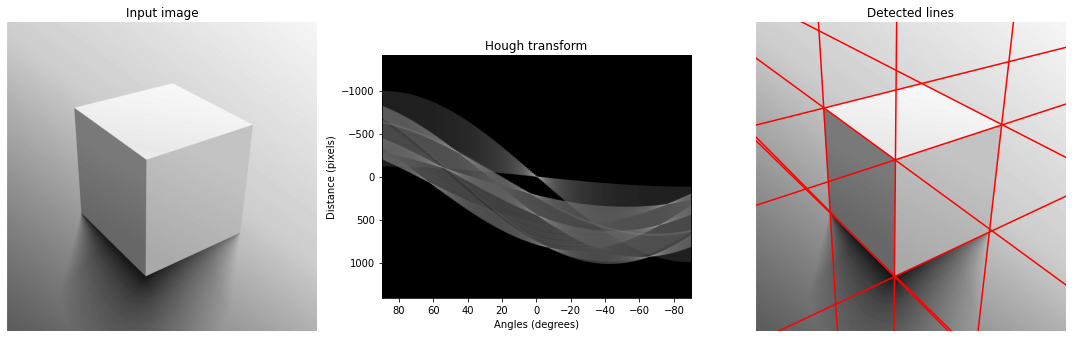

In [45]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny

from matplotlib import cm

def show_hough_transform(image):
    h, theta, d = hough_line(canny(image))  # вычисляем преобразование Хафа от границ изображения

    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(np.log(1 + h),
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap='gray', aspect=1/20)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')

    ax[2].imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
        ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()
    
cube = rgb2gray(imread('./cube.jpg'))
show_hough_transform(cube)

---

### Задание 1.

Подберите изображение, на котором с помощью преобразования Хафа можно найти несколько прямых. Результат работы на этом изображении функции `show_hough_transform` сохраните в `task_1.png`:

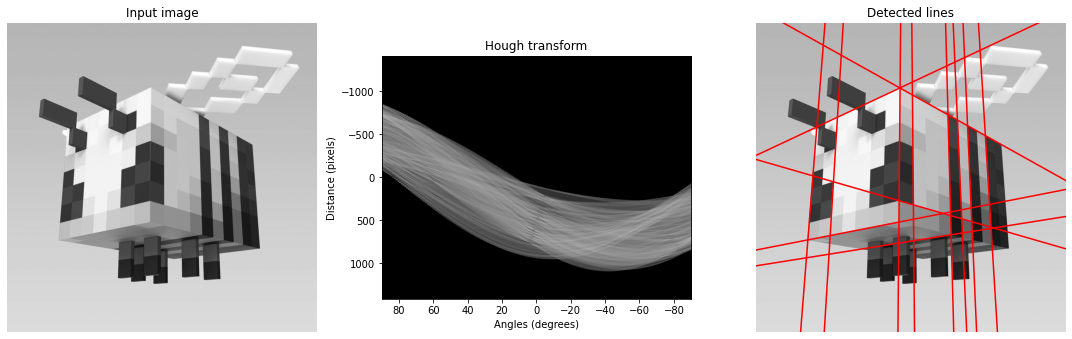

In [46]:
image_with_lines = rgb2gray(imread('steve.jpg'))

show_hough_transform(image_with_lines)
plt.savefig('task_1.png', dpi=150)

---

## Поиск границ

Часто возникает задача поиска границ на изображении: они могут быть использованы для распознавания образов (Object Detection), сегментации и классификации изображений. Так, в предыдущей задаче поиск линий осуществлялся именно на карте границ, а не на исходном изображении.

Посмотрим на различные фильтры, помогающие при выделении границ:

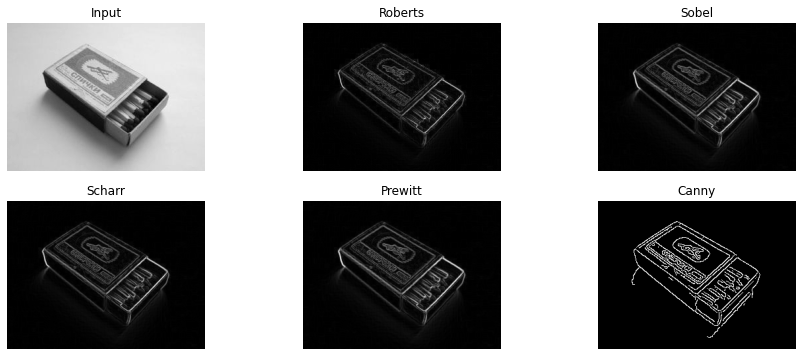

In [7]:
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.feature import canny

matchbox = rgb2gray(imread('matchbox.jpg')) # детекторы границ по умолчанию работают с одним каналом

fig, ax = plt.subplots(2, 3, figsize=(15, 6))
ax[0, 0].imshow(matchbox, cmap='gray')
ax[0, 1].imshow(roberts(matchbox), cmap='gray')
ax[0, 2].imshow(sobel(matchbox), cmap='gray')
ax[1, 0].imshow(scharr(matchbox), cmap='gray')
ax[1, 1].imshow(prewitt(matchbox), cmap='gray')
ax[1, 2].imshow(canny(matchbox), cmap='gray')
for i, title in enumerate(["Input", "Roberts", "Sobel", "Scharr", "Prewitt", "Canny"]): ax.flatten()[i].set_title(title)
for i in range(6): ax.flatten()[i].set_axis_off()

Фильтры Roberts, Sobel, Scharr, Prewitt вычисляют различные аппроксимации модуля градиента.

Детектор Canny - находит тонкие границы, соответствующие локальным максимумам модуля градиента. Поэтому зачастую граница состоит из набора коротких кривых. И для edge-based сегментации (выделения полного контура объекта) с помощью детектора Canny требуется подбирать параметры.

Выделим спичечный коробок на изображении двумя способами: с помощью карты границ, полученной детектором Canny, и с помощью так называемой region-based сегментации - методом [водораздела](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29), применяя аппроксимацию модуля градиента Собеля.

C:\Users\lfyz2\AppData\Local\Temp/ipykernel_14876/1393049968.py:1: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


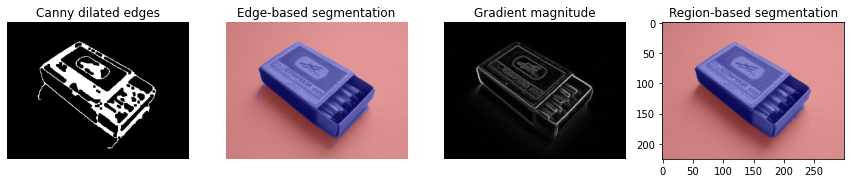

In [8]:
from scipy.ndimage.morphology import binary_fill_holes
from skimage.segmentation import watershed
from skimage.morphology import binary_closing, binary_erosion
from skimage.color import label2rgb

fig, ax = plt.subplots(1, 4, figsize=(15, 6))

canny_edge_map = binary_closing(canny(matchbox, sigma=1), selem=np.ones((4, 4)))
matchbox_edge_segmentation = binary_fill_holes(canny_edge_map)

ax[0].imshow(canny_edge_map, cmap='gray')
ax[1].imshow(label2rgb(matchbox_edge_segmentation, image=matchbox, bg_label=2))

# поставим маркеры фона и объекта
markers = np.zeros_like(matchbox)
markers[0:10, 0:10] = 1 # маркеры фона
markers[binary_erosion(canny_edge_map) > 0] = 2 # маркеры объекта - точки, находящиеся заведомо внутри

sobel_gradient = sobel(matchbox)
matchbox_region_segmentation = watershed(sobel_gradient, markers)

ax[2].imshow(sobel_gradient, cmap='gray')
ax[3].imshow(label2rgb(matchbox_region_segmentation, image=matchbox, bg_label=0))

for i, title in enumerate(["Canny dilated edges", "Edge-based segmentation", "Gradient magnitude", "Region-based segmentation"]): ax[i].set_title(title)
for i in range(3): ax[i].set_axis_off()

Визуально оба метода справились достаточно хорошо, но у каждого есть свои недостатки и преимущества:
* edge-based сегментация в данном случае дала не совсем корректный результат (в маску вошли две лишние кривые, идущие по тени), при этом вручную были подобраны параметры фильтра и ядра дилатации;
* для region-based пришлось вручную задать маркеры объекта - на практике такой информации могло бы и не быть.

---

### Задание 2.

* Подберите изображение, на котором можно выделить объект первым подходом (с помощью карты границ). При этом на изображении должен быть неоднородный фон;
* Найдите параметры детектора границ и морфологических операций, чтобы получить максимально точную маску.

Результат сохраните в файл `task_2.png`

C:\Users\lfyz2\AppData\Local\Temp/ipykernel_14876/896932556.py:6: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(label2rgb(my_edge_segmentation, image=easy_to_segment))


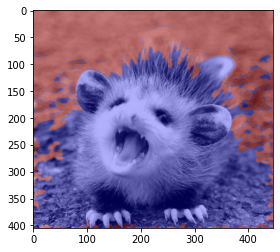

In [54]:
easy_to_segment = rgb2gray(imread('oposs.jpg'))

my_edge_map = binary_closing(canny(easy_to_segment, sigma=1.2), selem=np.ones((4, 4)))
my_edge_segmentation = binary_fill_holes(my_edge_map)

plt.imshow(label2rgb(my_edge_segmentation, image=easy_to_segment))
plt.savefig('task_2.png', dpi=150)

---


## Особые точки 

Особые точки - один из основных механизмов извлечения признаков для распознавания образов и локализации заданного объекта на изображении.

Существует несколько типов особых точек и дескрипторов:
* инвариантные к сдвигу, масштабированию и повороту - SIFT, SURF, FAST;
* инвариантные к масштабированию, но не к повороту - U-SURF;
* не инвариантные к масштабированию - Blob (обычно дескрипторы описывают соответствующие точки, но с разным значением радиуса);
* и другие.

Посмотрим на результаты работы различных детекторов:

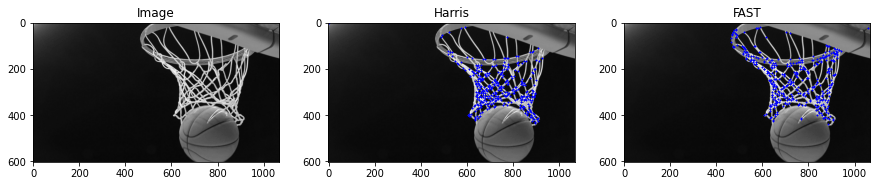

In [14]:
from skimage.feature import corner_harris, corner_peaks, corner_fast, corner_subpix
from skimage.transform import warp, AffineTransform

basketball = rgb2gray(imread("basketball.jpg"))

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].set_title('Image')
ax[0].imshow(basketball, cmap='gray')

# corner_harris возвращает матрицу, в которой максимумы соответствуют особым точкам
# поэтому чтобы извлечь координаты надо вызвать corner_peaks
basketball_harris = corner_peaks(corner_harris(basketball), threshold_rel=0.1)
ax[1].set_title('Harris')
ax[1].imshow(basketball, cmap='gray')
ax[1].plot(basketball_harris[:, 1], basketball_harris[:, 0], '+b', markersize=2)

basketball_fast = corner_peaks(corner_fast(basketball), threshold_rel=0.1)
ax[2].set_title('FAST')
ax[2].imshow(basketball, cmap='gray')
ax[2].plot(basketball_fast[:, 1], basketball_fast[:, 0], '+b', markersize=2)

Решим задачу стабилизации видеоряда: дана последовательность изображений (для простоты - два), требуется сделать так, чтобы объект занимал одно и то же положение в кадре.

Сначала сгенирируем данные искусственным образом: пусть камера немного повернулась против часовой стрелки и сдвинулась вверх.
Получим новую картинку поворотом старой на 3 градуса и сдвигом на 20 пикселей вправо и вниз, и посмотрим на особые точки:

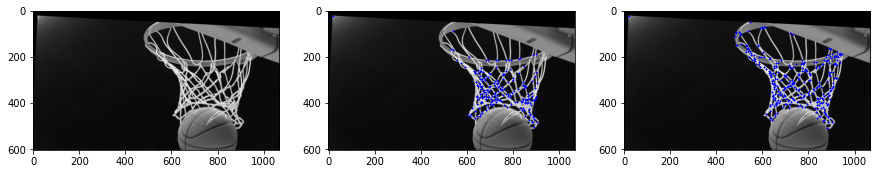

In [28]:
from skimage.transform import warp, AffineTransform

tform = AffineTransform(rotation=np.deg2rad(3), translation=(20, 20))
basketball2 = warp(basketball, tform.inverse, output_shape=basketball.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(basketball2, cmap='gray')

basketball2_harris = corner_peaks(corner_harris(basketball2), threshold_rel=0.1)
ax[1].imshow(basketball2, cmap='gray')
ax[1].plot(basketball2_harris[:, 1], basketball2_harris[:, 0], '+b', markersize=2)

basketball2_fast = corner_peaks(corner_fast(basketball2), threshold_rel=0.1)
ax[2].imshow(basketball2, cmap='gray')
ax[2].plot(basketball2_fast[:, 1], basketball2_fast[:, 0], '+b', markersize=2)

Видно, что часть особых точек находится в тех же местах объекта, где и была до поворота.

Найдём дескрипторы особых точек исходной и искажённой картинок, и сдвинем вторую картинку, чтобы она занимала исходное положение.

Для этого воспользуемся *ORB* - детектором (*Oriented FAST and rotated BRIEF*) и методом RANSAC для поиска аффинного преобразования, после чего применим обратное аффинное преобразование:

Оценка сдвига: [19.80622473 20.11692016]
Оценка поворота: -3.0046317394710997


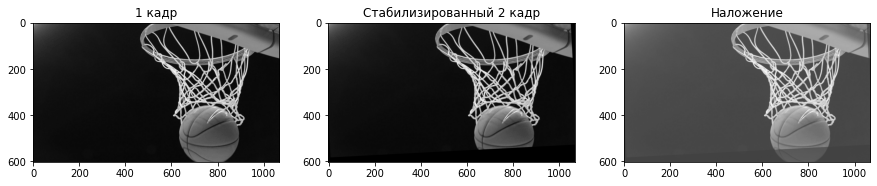

In [39]:
from skimage.feature import match_descriptors, ORB
from skimage.measure import ransac

orb = ORB()
orb.detect_and_extract(basketball)

orb2 = ORB()
orb2.detect_and_extract(basketball2)

basketball_match = match_descriptors(orb.descriptors, orb2.descriptors, cross_check=True)

src = orb.keypoints[basketball_match[:, 0]]
dst = orb2.keypoints[basketball_match[:, 1]]
    
estimated_transform, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=1000)

basketball3_stab = warp(basketball2, AffineTransform(translation=estimated_transform.translation,
                                                     rotation=-estimated_transform.rotation),
                        output_shape=basketball2.shape)


fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(basketball, cmap='gray')
ax[1].imshow(basketball3_stab, cmap='gray')
ax[2].imshow(basketball, cmap='gray', alpha=0.5)
ax[2].imshow(basketball3_stab, cmap='gray', alpha=0.5)

for i, title in enumerate(['1 кадр', 'Стабилизированный 2 кадр', 'Наложение']): ax[i].set_title(title)

print(f"Оценка сдвига: {estimated_transform.translation}")
print(f"Оценка поворота: {np.rad2deg(estimated_transform.rotation)}")

Видно, что подход работает достаточно хорошо, поэтому его часто применяют для решения аналогичных задач на практике. Существуют и другие подходы к решению данной задачи: оценка оптического потока (Optical Flow), и сопоставление с шаблоном с помощью преобразования Фурье.

Точно такую же технику можно использовать для решения задачи поиска гомографии, в частности - проективного преобразования, то есть для поиска отображения, преобразующего шаблонное изображение (например, qr-код) в объект на другом заданном изображении (снимке с камеры). С помощью найденной (или не найденной) гомографии можно установить есть ли объект на изображении, где он находится; исправить перспективу; отрендерить 3d-объект, чтобы он реалистично вписывался в сцену (AR), и другое.

---

### Задание 3 (дополнительное)
*Задание выполнять не обязательно, но оно позволяет получить 2 дополнительных балла за лабораторную.*

* Подберите два изображения, таких, что объект из первого изображения присутствует на втором изображении (можно сделать две фотографии: объекта отдельно и объекта в окружении), см. пример внизу;
* Найдите гомографию, используя метод `cv2.findHomography` и один из способов поиска особых точек;
* Задайте на первом изображении четырёхугольник, ограничивающий объект;
* Обведите четырёхугольником найденный объект на втором изображении, используя `cv2.warpPerspective` или `cv2.perspectiveTransform`;
* Сохрание в файл `task_3.png` результат - картинку, на которой слева первое изображение с четырёхугольником, ограничивающим объект (этот четырёхугольник задавался вручную), справа - второе изображение с четырёхугольников, ограничивающим объект (этот четырёхугольник был получен перспективным преобразованием).

![Homography](https://www.learnopencv.com/wp-content/uploads/2016/01/homography-example.jpg)

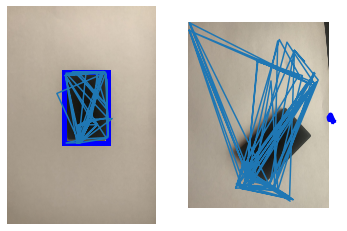

In [77]:
from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening
from matplotlib.patches import Rectangle
from skimage.measure import regionprops
from skimage.measure import label as sk_measure_label

def get_largest_component(mask):
    labels = sk_measure_label(mask)
    props = regionprops(labels)
    areas = [prop.area for prop in props]
    largest_comp_id = np.array(areas).argmax()
    return labels == (largest_comp_id + 1)
flash1original = imread("aaa.jpg")
flash2original = imread("bbbb.jpg")

flash1 = rgb2gray(flash1original)
flash2 = rgb2gray(flash2original)

#
#calculate rectangle
thresh_otsu = threshold_otsu(flash1)
res_otsu = flash1 <= thresh_otsu

res_otsu_enclosed = binary_opening(res_otsu, selem=np.ones((5, 5)))

res = get_largest_component(res_otsu_enclosed)

vertical_indices = np.where(np.any(res, axis=1))[0]
top, bottom = vertical_indices[0], vertical_indices[-1]

horizontal_indices = np.where(np.any(res, axis=0))[0]
left, right = horizontal_indices[0], horizontal_indices[-1]
#
#draw first rect
f, ax = plt.subplots(1, 2)
for i in range(2): ax[i].set_axis_off()
ax[0].imshow(flash1original)
ax[1].imshow(flash2original)

corner = (left, top)
height = bottom - top
width = right - left
rect = Rectangle(corner, width, height, linewidth=5, edgecolor='b', facecolor='none')
ax[0].add_patch(rect)
#
#calculate and draw second rect
points = np.array([[[left, top], [right, top], [right, bottom], [left, bottom]]], dtype=np.float32)
result_points = cv2.perspectiveTransform(points, transform[0])
xplot = result_points[0][:, 0]
xplot = np.resize(xplot, (5))
yplot = result_points[0][:, 1]
yplot = np.resize(yplot, (5))
ax[1].plot(xplot, yplot, '-b', linewidth=5)
##
ax[0].plot(src[:, 1], src[:,0])
ax[1].plot(dst[:, 1], dst[:,0])
